In [1]:
import pandas as pd
import spacy
import pprint as pprint
import numpy as np
import os
import random
import torch
import math
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

In [4]:
PROCESSED_DATA_DIR = "processed_data"
MODEL_NAME = "BERT_Attention"
model = BertModel.from_pretrained('bert-base-uncased').to(device) 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
nlp = spacy.load('en')

In [5]:
def get_bert_embeddings(passage_text):
    passage_text_processed = nlp(passage_text)
    passage_with_separators = ' '.join(['[CLS]'] + [sent.text + ' [SEP]' for sent in passage_text_processed.sents])
    passage_with_separators_tokenized = tokenizer.tokenize(passage_with_separators)    
    model.eval()
    indexed_tokens = tokenizer.convert_tokens_to_ids(passage_with_separators_tokenized)
    tokens_tensor = torch.tensor([indexed_tokens]).to(device)

    with torch.no_grad():
        encoded_layers, _ = model(tokens_tensor)

    indices = [i for i, w in enumerate(passage_with_separators_tokenized) if (w not in ['[CLS]', '[SEP]'])]
    nonseparator_tokens = [w for i, w in enumerate(passage_with_separators_tokenized) if (w not in ['[CLS]', '[SEP]'])]
    nonseparators = torch.squeeze(encoded_layers[-1])[indices][:]

    attn_vectors_per_word = []
    encountered_words = []
    i = 0
    carry_over = None
    had_carry_over = False
    
    for w_i, word in enumerate(passage_text_processed):
        word = word.text.lower()
        first_attention_vector = nonseparators[i]
        current_word = ''
        if word == ' ':
            attn_vectors_per_word.append(first_attention_vector)
            continue
        if carry_over:
            current_word = carry_over
            carry_over = None
        while current_word[:len(word)] != word:
            current_token = nonseparator_tokens[i]
            current_word += (current_token if (current_token[:2] != '##') else current_token[2:])
            i += 1
        encountered_words.append(current_word)
        if not had_carry_over:
            attn_vectors_per_word.append(first_attention_vector)
        else:
            had_carry_over = False
        if len(current_word) > len(word):
            attn_vectors_per_word.append(first_attention_vector)
            carry_over = current_word[len(word):]
            had_carry_over = True
    output = torch.stack(attn_vectors_per_word)
    assert len([word for word in passage_text_processed]) == len(attn_vectors_per_word)
    return output

In [6]:
train_passages = np.load("processed_data/train_passage_list.npy")

In [7]:
train_embeddings = []
for i,passage in enumerate(train_passages):
    print("processing doc", i)
    embeddings = get_bert_embeddings(str(passage))
    train_embeddings.append(embeddings)

processing doc 0
processing doc 1
processing doc 2
processing doc 3
processing doc 4
processing doc 5
processing doc 6
processing doc 7
processing doc 8
processing doc 9
processing doc 10
processing doc 11
processing doc 12
processing doc 13
processing doc 14
processing doc 15
processing doc 16
processing doc 17
processing doc 18
processing doc 19
processing doc 20
processing doc 21
processing doc 22
processing doc 23
processing doc 24
processing doc 25
processing doc 26
processing doc 27
processing doc 28
processing doc 29
processing doc 30
processing doc 31
processing doc 32
processing doc 33
processing doc 34
processing doc 35
processing doc 36
processing doc 37
processing doc 38
processing doc 39
processing doc 40
processing doc 41
processing doc 42
processing doc 43
processing doc 44
processing doc 45
processing doc 46
processing doc 47
processing doc 48
processing doc 49
processing doc 50
processing doc 51
processing doc 52
processing doc 53
processing doc 54
processing doc 55
pr

processing doc 438
processing doc 439
processing doc 440
processing doc 441
processing doc 442
processing doc 443
processing doc 444
processing doc 445
processing doc 446
processing doc 447
processing doc 448
processing doc 449
processing doc 450
processing doc 451
processing doc 452
processing doc 453
processing doc 454
processing doc 455
processing doc 456
processing doc 457
processing doc 458
processing doc 459
processing doc 460
processing doc 461
processing doc 462
processing doc 463
processing doc 464
processing doc 465
processing doc 466
processing doc 467
processing doc 468
processing doc 469
processing doc 470
processing doc 471
processing doc 472
processing doc 473
processing doc 474
processing doc 475
processing doc 476
processing doc 477
processing doc 478
processing doc 479
processing doc 480
processing doc 481
processing doc 482
processing doc 483
processing doc 484
processing doc 485
processing doc 486
processing doc 487
processing doc 488
processing doc 489
processing d

processing doc 871
processing doc 872
processing doc 873
processing doc 874
processing doc 875
processing doc 876
processing doc 877
processing doc 878
processing doc 879
processing doc 880
processing doc 881
processing doc 882
processing doc 883
processing doc 884
processing doc 885
processing doc 886
processing doc 887
processing doc 888
processing doc 889
processing doc 890
processing doc 891
processing doc 892
processing doc 893
processing doc 894
processing doc 895
processing doc 896
processing doc 897
processing doc 898
processing doc 899
processing doc 900
processing doc 901
processing doc 902
processing doc 903
processing doc 904
processing doc 905
processing doc 906
processing doc 907
processing doc 908
processing doc 909
processing doc 910
processing doc 911
processing doc 912
processing doc 913
processing doc 914
processing doc 915
processing doc 916
processing doc 917
processing doc 918
processing doc 919
processing doc 920
processing doc 921
processing doc 922
processing d

In [8]:
test_passages = np.load("processed_data/test_passage_list.npy")

In [9]:
test_embeddings = []
for i,passage in enumerate(test_passages):
    print("processing doc", i)
    embeddings = get_bert_embeddings(str(passage))
    test_embeddings.append(embeddings)

processing doc 0
processing doc 1
processing doc 2
processing doc 3
processing doc 4
processing doc 5
processing doc 6
processing doc 7
processing doc 8
processing doc 9
processing doc 10
processing doc 11
processing doc 12
processing doc 13
processing doc 14
processing doc 15
processing doc 16
processing doc 17
processing doc 18
processing doc 19
processing doc 20
processing doc 21
processing doc 22
processing doc 23
processing doc 24
processing doc 25
processing doc 26
processing doc 27
processing doc 28
processing doc 29
processing doc 30
processing doc 31
processing doc 32
processing doc 33
processing doc 34
processing doc 35
processing doc 36
processing doc 37
processing doc 38
processing doc 39
processing doc 40
processing doc 41
processing doc 42
processing doc 43
processing doc 44
processing doc 45
processing doc 46
processing doc 47
processing doc 48
processing doc 49
processing doc 50
processing doc 51
processing doc 52
processing doc 53
processing doc 54
processing doc 55
pr

In [246]:
print(len(train_embeddings), len(test_embeddings), len(train_embeddings[0][0]), len(test_embeddings[0][0]))

1189 133 768 768


In [338]:
total_positive_pairs = np.load("./processed_data/train_positive_pairs.npy")
total_negative_pairs = np.load("./processed_data/train_negative_pairs.npy")
test_positive_pairs = np.load("./processed_data/test_positive_pairs.npy")
test_negative_pairs = np.load("./processed_data/test_negative_pairs.npy")
train_positive_pairs = total_positive_pairs[0:1000]
train_negative_pairs = total_negative_pairs[0:1000]
valid_positive_pairs = total_positive_pairs[1000:]
valid_negative_pairs = total_negative_pairs[1000:]

In [339]:
X_train = []
Y_train = []
X_valid = []
Y_valid = []
X_test = []
Y_test = []

In [340]:
for i, doc_pairs in enumerate(train_positive_pairs):
    for coref_pair in doc_pairs:
        sample = [i, coref_pair[0][0], coref_pair[0][1], coref_pair[1][0], coref_pair[1][1]]
        X_train.append(sample)
        Y_train.append([1])
for i, doc_pairs in enumerate(train_negative_pairs):
    for coref_pair in doc_pairs:
        sample = [i, coref_pair[0][0], coref_pair[0][1], coref_pair[1][0], coref_pair[1][1]]
        X_train.append(sample)
        Y_train.append([0])

In [341]:
for i, doc_pairs in enumerate(valid_positive_pairs):
    for coref_pair in doc_pairs:
        sample = [i, coref_pair[0][0], coref_pair[0][1], coref_pair[1][0], coref_pair[1][1]]
        X_valid.append(sample)
        Y_valid.append([1])
for i, doc_pairs in enumerate(valid_negative_pairs):
    for coref_pair in doc_pairs:
        sample = [i, coref_pair[0][0], coref_pair[0][1], coref_pair[1][0], coref_pair[1][1]]
        X_valid.append(sample)
        Y_valid.append([0])

In [342]:
for i, doc_pairs in enumerate(test_positive_pairs):
    for coref_pair in doc_pairs:
        sample = [i, coref_pair[0][0], coref_pair[0][1], coref_pair[1][0], coref_pair[1][1]]
        X_test.append(sample)
        Y_test.append([1])
for i, doc_pairs in enumerate(test_negative_pairs):
    for coref_pair in doc_pairs:
        sample = [i, coref_pair[0][0], coref_pair[0][1], coref_pair[1][0], coref_pair[1][1]]
        X_test.append(sample)
        Y_test.append([0])

In [343]:
shuffled_idx = list(np.random.permutation(len(X_train)))
X_train = np.array([X_train[i] for i in shuffled_idx])
Y_train = np.array([Y_train[i] for i in shuffled_idx])

In [344]:
shuffled_idx = list(np.random.permutation(len(X_valid)))
X_valid = np.array([X_train[i] for i in shuffled_idx])
Y_valid = np.array([Y_train[i] for i in shuffled_idx])

In [345]:
shuffled_idx = list(np.random.permutation(len(X_test)))
X_test = np.array([X_test[i] for i in shuffled_idx])
Y_test = np.array([Y_test[i] for i in shuffled_idx])

In [346]:
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt

In [347]:
def get_featues_from_pairs(X_batch, embeddings):
    batch_embeddings = []
    for x in X_batch:
        doc_id, a_start, a_end, b_start, b_end = x 
        doc_emb = embeddings[doc_id]
        emb_a = torch.sum(doc_emb[a_start:a_end+1], 0)
        emb_b = torch.sum(doc_emb[b_start:b_end+1], 0)
        emb_dot = torch.mul(emb_a, emb_a)
        emb_cat   = torch.cat((emb_a, emb_b), 0)
        emb   = torch.cat((emb_cat, emb_dot), 0)
        batch_embeddings.append(emb)
    return torch.stack(batch_embeddings)

In [348]:
def confusion(prediction, truth):
    confusion_vector = prediction / truth
    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

In [349]:
def calculate_f1(Y, y_preds):
    y_actuals = torch.tensor(Y).type(torch.float32).to(device)
    y_preds = y_preds.to(device)
    tp, fp, tn, fn = confusion(y_preds, y_actuals)
    precision = tp*1.0/(tp+fp)
    recall   = tp*1.0/(tp+fn)
    f1 = 2.0*precision*recall/(precision+recall)
    return precision, recall, f1

In [357]:
def train_epoch(model, opt, criterion, batch_size, X_data, Y_data, embeddings, mode="train"):
    
    if(mode == "train"):
        model.train()
    else:
        model.eval()
    
    losses = []
    running_corrects = 0
    shuffled_idx = list(np.random.permutation(len(X_data)))
    minibatch_idxs = np.array_split(shuffled_idx, len(shuffled_idx)/batch_size) 
    ones = 0
    zeros = 0
    y_preds_all = torch.Tensor().to(device)
    y_shuffled_all = torch.Tensor().to(device)
    for minibatch_ids in minibatch_idxs:
        x_batch_raw = X_data[minibatch_ids]
        x_batch = get_featues_from_pairs(x_batch_raw, embeddings)
        y_batch = torch.tensor(Y_data[minibatch_ids]).type(torch.float32)
        x_batch = Variable(x_batch).to(device)
        y_batch = Variable(y_batch).to(device)
        opt.zero_grad()
        
        if(mode == "train"):
            y_hat = model(x_batch)
        else:
            with torch.no_grad():
                y_hat = model(x_batch)
        
        y_preds = (y_hat > 0.7).type(torch.float32)
        loss = criterion(y_hat, y_batch)
        corrects = float(torch.sum(y_preds == y_batch).item())
        running_corrects += corrects
        ones  += torch.sum(y_preds==1).item()
        zeros +=  torch.sum(y_preds==0).item()
        if(mode == "train"):
            loss.backward()
            opt.step()    
        losses.append(loss.item())
        y_preds_all = torch.cat((y_preds_all,y_preds))
        y_shuffled_all = torch.cat((y_shuffled_all,y_batch))
    print("ones and zeros", ones, zeros)
    accuracy = running_corrects * 1.0 / len(shuffled_idx)
    avg_loss = sum(losses) * 1.0 / len(losses)
    precision, recall, F1 = calculate_f1(y_shuffled_all, y_preds_all)
    return avg_loss, accuracy, precision, recall, F1

In [358]:
def predict(model, X, embeddings):
    model.eval()
    idxs = range(0, len(X))
    minibatch_idxs = np.array_split(idxs, len(idxs)/batch_size)
    y_preds_all = torch.Tensor().to(device)
    y_hats_all = torch.Tensor().to(device)
    for minibatch_ids in minibatch_idxs:
        x_batch_raw = X[minibatch_ids]
        x_batch = get_featues_from_pairs(x_batch_raw, embeddings)
        x_batch = Variable(x_batch).to(device)
        opt.zero_grad()
        with torch.no_grad():
                y_hats = model(x_batch)
        y_preds = (y_hats > 0.9).type(torch.float32)
        y_preds_all = torch.cat((y_preds_all,y_preds))
        y_hats_all = torch.cat((y_preds_all,y_hats))
    return y_preds_all, y_hats_all

In [359]:
def evaluate(model, X, Y, embeddings):
    y_preds, y_hats = predict(model, X, embeddings)
    Y = Variable(torch.tensor(Y).type(torch.float32)).to(device)
    corrects = float(torch.sum(y_preds == Y).item())
    accuracy = corrects * 1.0 / Y.size()[0]
    return accuracy,y_preds, y_hats

In [360]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [361]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(768*3, 512)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 64)
        self.relu2 = nn.ReLU()
        self.out = nn.Linear(64, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.relu2(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y

In [362]:
net = Net().to(device)
net.apply(init_weights)
opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
batch_size = 1024
num_epochs = 30
criterion = nn.BCELoss() #pos_weight=torch.tensor([0.8,1]), pos_weight=torch.tensor([0.8,1])

In [363]:
train_loss_seq = []
val_loss_seq = []
train_acc_seq = []
val_acc_seq = []
for e in range(num_epochs):
    print("================ EPOCH", e, "/", num_epochs)
    train_loss, train_acc, precision, recall, f1 = train_epoch(net, opt, criterion, batch_size, X_train, Y_train, train_embeddings,"train")
    val_loss, val_acc, precision, recall, f1 = train_epoch(net, opt, criterion, batch_size, X_valid, Y_valid, train_embeddings, "validation")
    train_loss_seq.append(train_loss)
    train_acc_seq.append(train_acc)
    val_loss_seq.append(val_loss)
    val_acc_seq.append(val_acc)
    print("Train loss and accuracy, prf1: ", train_loss, train_acc,precision, recall, f1)
    print("Val loss and accuracy, prf1: ", val_loss, val_acc,precision, recall, f1)

================ EPOCH 0 / 30
ones and zeros 13004 830730


/home/forcerequestspring19_gmail_com/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


ones and zeros 20515 676993
Train loss and accuracy, prf1:  0.19487680378907507 0.9482324998162928 0.9244455276626858 0.43356499474189564 0.5902858832500738
Val loss and accuracy, prf1:  0.10245514153974697 0.9622556300429529 0.9244455276626858 0.43356499474189564 0.5902858832500738
================ EPOCH 1 / 30
ones and zeros 26413 817321
ones and zeros 26433 671075
Train loss and accuracy, prf1:  0.10160854835411758 0.963676940836804 0.9464684296144971 0.5719445841525308 0.7130174563591024
Val loss and accuracy, prf1:  0.07489565611651465 0.9711272128778451 0.9464684296144971 0.5719445841525308 0.7130174563591024
================ EPOCH 2 / 30
ones and zeros 30810 812924
ones and zeros 26555 670953
Train loss and accuracy, prf1:  0.08443512863061987 0.9690186717614794 0.9700244774995292 0.588884824653651 0.7328619998008451
Val loss and accuracy, prf1:  0.0640199831392884 0.9730770113030962 0.9700244774995292 0.588884824653651 0.7328619998008451
================ EPOCH 3 / 30


KeyboardInterrupt: 

In [234]:
torch.save(net.state_dict(), "processed_data/negative_samples_run.pth")

In [297]:
model = Net()
model.load_state_dict(torch.load("processed_data/second_run.pth"))
model.to(device)
model.eval()

Net(
  (fc1): Linear(in_features=2304, out_features=512, bias=True)
  (relu1): ReLU()
  (dout): Dropout(p=0.4)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (relu2): ReLU()
  (out): Linear(in_features=64, out_features=1, bias=True)
  (out_act): Sigmoid()
)

In [308]:
y_preds, y_hats = predict(model, X_test, test_embeddings)

In [309]:
accuracy, y_preds, y_hats = evaluate(model, X_test, Y_test, test_embeddings)

In [310]:
numpy_y_preds = y_preds.view(1, y_preds.size()[0]).to("cpu").numpy()[0].astype(int)
numpy_y_actuals = Y_test.reshape(1, Y_test.shape[0])[0].astype(int)

In [311]:
calculate_f1(Y_test,y_preds)

(0.7580023907557445, 0.5984062074027472, 0.6688151880932849)

In [301]:
from sklearn.metrics import confusion_matrix

In [302]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [303]:
numpy_y_preds

array([0, 0, 0, ..., 0, 0, 0])

In [304]:
unique_labels(numpy_y_preds)

array([0, 1])

Confusion matrix, without normalization
[[138980   3520]
 [  2982   6555]]


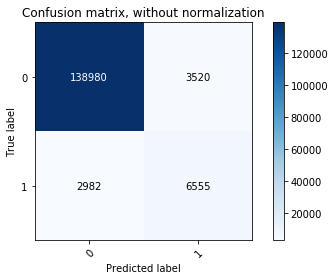

In [305]:
classes = np.array([0,1])
plot_confusion_matrix(numpy_y_actuals, numpy_y_preds, classes)

### Clustering